In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/PI02 dataton Soy Henry/Copy of train.parquet')

In [ ]:
# seleccionamos los campos ha ser usados, los demas campos fuerón descartados por tener demasiados datos nulos, o son datos irrelevantes

campos = ['price','type','sqfeet','beds','baths','cats_allowed','cats_allowed','dogs_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished']
df_prueba = df[campos]

In [ ]:
# nos aseguramos de eliminar los registros donde los precios son nulos debido a que este dato es indispensable para generar el tarjet
df_prueba = df_prueba[df_prueba['price'].notna()] 

In [ ]:
#creamos un dataframe con una sola columna tarjet 
df_tarjet = pd.DataFrame(columns=['tarjet'],index=range(346479))


In [ ]:
#rellenamos los datos de la columna tarjet teniendo en cuenta las indicasiones del proyecto 
for i in range(0,346478,1):
  if( df_prueba['price'][i] >= 0 and df_prueba['price'][i] <= 999 ):
    df_tarjet['tarjet'][i] = 0 #agremos cero si es menor igual a 999 y mayor que 0 

  elif ( df_prueba['price'][i] >= 1000 and df_prueba['price'][i] <= 1999 ):
    df_tarjet['tarjet'][i] = 1
  
  elif( df_prueba['price'][i] >= 2000  ):
    df_tarjet['tarjet'][i] = 2

#concatenamos el dataframe de los datos con el dataframe que contiene los tarjets
df = pd.concat([df_prueba,df_tarjet], ignore_index=True, axis = 1)

encabezado = ['price','type','sqfeet','beds','baths','cats_allowed','cats_allowed','dogs_allowed','smoking_allowed',
              'wheelchair_access','electric_vehicle_charge','comes_furnished','laundry_options','parking_options','tarjet']
df = df.set_axis(encabezado, axis=1) #seteamos nuevamente los encabezados ya que estos se pierden cuando concatenamos los dataframes

#eliminamos la columna price ya que no lo necesitamos más
df = df.drop(['price'], axis=1)


In [ ]:
#ya creado el tarjet guardamos los nuevos datos en un archivo csv
df.to_csv('/content/drive/MyDrive/PI02 dataton Soy Henry/train.csv', index = False)

PREPROCESAMIENTO DE DATOS

In [ ]:
#leemos los nuevos datos de entrenamiento
data = pd.read_csv('/content/drive/MyDrive/PI02 dataton Soy Henry/train.csv') 

In [ ]:
# creamos variables artificiales para trabajar con datos categóricos "type"
data = pd.get_dummies(data, columns=["type"])

In [ ]:
# separamos nuestros datos para las variables X e Y
y = data['tarjet'] #asignamos  nuestro tarjet a la variable "y"

 # asignamos todos los datos a X excepto el tarjet, beds, baths 
X = data.drop(['tarjet','beds','baths'], axis=1) #no trabajamos con baths porque estos tienen 1 alto grado de correlación por lo que influye  negativamente en el modelo


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [ ]:
# normalizamos nuestros datos
X = Normalizer(norm='l1').fit_transform(X)

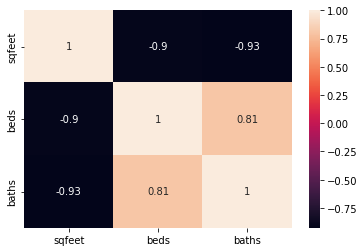

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
dataframe_aux = pd.DataFrame(X[:,0:3])
dataframe_aux = dataframe_aux.set_axis(['sqfeet','beds','baths'], axis=1)
corr = dataframe_aux.corr()

sns.heatmap(corr, annot=True)
plt.show()
# podemos ver en la gráfica lo que se mencionó anteriormente hay demasiada correlación entre "sqfeet", "beds", "baths"
#por lo que se tomó la decisión de solo trabajar con "sqfeet"

In [ ]:
# dividimos nuestra data en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
import datetime

In [ ]:
 # configuramos early stopping para que se detenga el proceso de entrenamiento cuando este no muestre mejoras tras 8 epocas
early_stop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=8)

In [ ]:
#creamos el modelo con 20 variables de entrada y 3 capas ocultas con 60,45 y 20 neuronas respectivamente ademas usamos la función softmax para la capa de salida
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 60, activation = 'relu', input_shape = (20,)))
model.add(tf.keras.layers.Dense(units = 45, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 20, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs =50,callbacks=[tensorboard_callback,early_stop])

!tensorboard --logdir=logs/fit


In [ ]:
#guardamos la arquitectura y los pesos del modelo para que no se pierda cuando cerremos el notebook
model.save('/content/drive/MyDrive/PI02 dataton Soy Henry/model.h5')
model.save_weights('/content/drive/MyDrive/PI02 dataton Soy Henry/pesos.h5') 

In [ ]:
#cargamos el modelo guardado
model_produccion = tf.keras.models.load_model('/content/drive/MyDrive/PI02 dataton Soy Henry/model.h5')

In [ ]:
#cargamos los datos que test para realizar predicciones
production_data=pd.read_parquet('/content/drive/MyDrive/PI02 dataton Soy Henry/Copy of test.parquet')


In [ ]:
#elaboramos el preprocesamiento de datos antes de ingresar al modelo
campos = ['type','sqfeet','beds','baths','cats_allowed','cats_allowed','dogs_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished']
production_data = production_data[campos]
production_data = pd.get_dummies(production_data, columns=["type"])


In [ ]:
#realizamos las predicciones
production_predictions = model.predict(production_data)

1204/1204 [==============================] - 2s 1ms/step


In [ ]:
#damos formato a las predicciones del modelo para que tengan una sola columna y las respuestas sean reemplazadas por 'low' 'medium' 'high'
pred = []
production_predictions = pd.DataFrame(production_predictions)
for i in range(0,38497,1):
  if production_predictions[0][i] == 1:
    pred.append('low')
  elif production_predictions[1][i] == 1:
    pred.append('medium')
  elif production_predictions[2][i] == 1:
    pred.append('high')

In [ ]:
#convertimos la lista que contiene las predicciones del modelo a dataframe 
pred = pd.DataFrame(pred)

In [ ]:
#finalmente exportamos las predcciones a formato csv
pred.to_csv('/content/drive/MyDrive/PI02 dataton Soy Henry/pred.csv', index = False)